In [ ]:
!pip install pydub

In [ ]:
#######################################importing library####################################################
import librosa
import numpy as np

In [ ]:
#######to generalize our model for real time test cases (recorded or from youtube) we downloaded these classes audio set from youtube in mp3 format:
'''
links are these:
Dog_bark; https://youtu.be/nKG-BtVa9F8
Car_horn: https://youtu.be/TF0cKfS07-U
Air_conditioner: https://youtu.be/jCHGex4nLp8
Engine_idling: https://youtu.be/A7YDh8y3RjE
Drilling: https://youtu.be/e-BXOP0_hog
Jackhammer: https://youtu.be/yPMdmhGt8g0
Street_music:https://youtu.be/PgnGKFwL0kY
Children_play:https://youtu.be/wAjKpdokhls
Gun_shot:https://youtu.be/FidGPhNC4sc
Siren:https://youtu.be/R3auDuKEnaA

'''

In [ ]:
##############################################Code to convert mp3 files to wav files, for example engine idling##########################
from os import path
from pydub import AudioSegment
  
# assign files
input_file = ('/content/drive/MyDrive/ML_N/Engine_idling.mp3')
output_file = ('/content/drive/MyDrive/ML_N/Engine_idling.wav')
  
# convert mp3 file to wav file
sound = AudioSegment.from_mp3(input_file)
sound.export(output_file, format="wav")

<_io.BufferedRandom name='/content/drive/MyDrive/ML_N/Engine_idling.wav'>

In [ ]:
##########################Breaking a 6 min wav file into 100 chunks of 4 seconds each, for example engine idling#####################################

from pydub import AudioSegment
from pydub.utils import make_chunks

myaudio = AudioSegment.from_file("/content/drive/MyDrive/ML_N/Engine_idling.wav" , "wav") 
chunk_length_ms = 4000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

#Export all of the individual chunks as wav files
index=0
for i, chunk in enumerate(chunks):
  chunk_name = "/content/drive/MyDrive/ML_N/Engine_idling/Engine_idling"+str(index)+".wav".format(i)
  print ("exporting", chunk_name)
  chunk.export(chunk_name, format="wav")
  index=index+1

Tri-training with majority votes

In [ ]:
# all models tri training predictions 

list=['Air_conditioner','Car_horn','Children_play','Dog_bark','Drilling','Engine_idling','Gun_shot','Jackhammer','Siren','Street_music']
import glob
sample_r = []
feature = []

import keras
m1 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/CRNN_80.h5')  
m2 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/MLP_80.h5') 
m3 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/LSTM_80.h5')  

#############################################Feature extraction#############################################################
def parser(row):
    # Function to load files and extract features
    feature=[]
    f=glob.glob(row+'/'+'*.wav')
    for i in range(len(f)):
        #file_name = '/content/drive/MyDrive/Dataset/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        X, sample_rate = librosa.load(f[i], res_type='kaiser_fast') 
        from sklearn import preprocessing
        #X=preprocessing.normalize(X.reshape(16,8)).reshape(128,)
        
        feature.append(X)
        sample_r.append(sample_rate)
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0) 
        
        #print(mels.shape)      
        #feature.append(mels)
        #label.append(df["classID"][i])
    return feature, sample_r


######################Extracting features of all the wav files of all classes##########################################################
features=[]
X_total=[]
y_total_pred=[]
y_correct=[]
y_real=[]
index=0
for i in list:
  F=[]
  F, sample_rate = parser('/content/drive/MyDrive/ML_N/'+i)
  print(index)
  
  features.append(F)
  x_ = []
  X_test=[]
  y_pred=[]
  print(len(F))
  for j in range(len(F)):
    y_real.append(index)
    mels = np.mean(librosa.feature.melspectrogram(y=F[j], sr=sample_rate[j]).T,axis=0)
    #print(mels.shape)
    from sklearn import preprocessing
    mels=preprocessing.normalize(mels.reshape(16,8)).reshape(128,)
    mels=np.reshape(mels, (128,))
    x_.append(mels)
    y_correct.append(index-1)
    X_total.append(mels)
  print(len(x_))
  x=np.array(x_)

  X_test.append(x)
  print(x.shape)
  y1 = m1.predict(x.reshape(len(x), 16,8,1))
  y2 = m2.predict(x)
  y3 = m3.predict(x.reshape(len(x), 16,8))
  index+=1
  y = []
  for k in range(len(y1)):
    p_1 = y1[k][np.argmax(y1[k])]
    p_2 = y2[k][np.argmax(y2[k])]
    p_3 = y3[k][np.argmax(y3[k])]
    p_max = max(max(p_1, p_2), p_3)
    if np.argmax(y1[k])==np.argmax(y2[k]) and (p_1>=0.85 or p_2>=0.85):
      y.append(y1[k])
    elif np.argmax(y2[k])==np.argmax(y3[k]) and (p_2>=0.85 or p_3>=0.85):
      y.append(y2[k])
    elif np.argmax(y3[k])==np.argmax(y1[k]) and (p_3>=0.85 or p_1>=0.85):
      y.append(y3[k])
    else:
      if p_max==p_1:
        y.append(y1[k])
      elif p_max==p_2:
        y.append(y2[k])
      elif p_max==p_3:
        y.append(y3[k])


  y = np.argmax(y, axis=1)
  
  y_total_pred=y_total_pred+y.tolist()
  print(y)


#print(X_total.shape,y_total_pred.shape)

0
88
88
(88, 128)
[0 7 9 9 9 9 7 7 7 7 9 9 9 7 9 9 9 9 9 9 9 9 7 7 9 9 9 9 7 9 7 9 9 9 9 9 9
 9 9 7 9 9 7 7 9 9 9 9 9 9 7 9 9 9 7 7 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 9 7 7
 9 7 7 9 9 7 9 9 9 9 9 5 5 5]
1
80
80
(80, 128)
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9]
2
76
76
(76, 128)
[3 2 8 2 2 4 2 3 2 4 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 3 2 2 2 2 2 6 2 2 2 0 8
 2 8 8 4 2 2 0 2 4 2 2 2 6 3 8 2 2 2 2 2 3 2 2 2 2 3 3 3 2 2 2 3 4 2 9 2 5
 7 2]
3
76
76
(76, 128)
[3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 8 8 8 3 3 3 2 2 2 3 2 3 2 3 2
 3 2 2 2 3 2 2 2 2 8 2 2 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9
 4 0]
4
70
70
(70, 128)
[6 9 9 4 4 2 4 2 4 3 4 4 4 4 4 4 4 4 4 4 7 6 4 4 3 4 4 4 0 6 6 4 4 0 9 9 9
 9 4 4 9 4 7 4 4 5 4 4 4 5 7 7 4 7 7 7 4 7 4 7 7 7 4 7 4 4 7 4 7 4]


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


5
75


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


75
(75, 128)
[9 9 9 0 2 9 2 5 5 6 5 9 3 3 8 2 8 5 7 9 9 9 9 9 9 9 9 0 5 5 5 5 5 8 5 2 5
 2 5 5 0 2 2 2 5 5 5 5 2 5 5 2 2 2 2 0 9 0 0 6 5 1 8 0 0 0 0 6 2 5 0 0 2 0
 9]
6
98
98
(98, 128)
[4 7 0 2 0 4 5 2 2 4 7 6 6 2 6 2 6 6 7 0 6 6 2 6 6 2 0 1 9 3 2 9 3 9 4 4 6
 2 0 2 4 3 6 2 4 2 6 2 6 0 6 6 2 8 4 6 6 5 0 4 0 7 2 2 8 2 0 6 6 6 6 4 7 3
 3 9 3 2 6 3 3 7 4 4 6 5 4 3 6 0 2 2 2 6 2 6 7 2]


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


7
151


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


151
(151, 128)
[4 7 4 7 7 4 7 4 4 7 4 4 4 7 7 7 4 4 4 4 4 4 7 7 7 7 7 7 7 7 6 4 7 4 7 7 4
 7 4 7 7 7 4 7 4 7 7 4 4 4 7 4 7 7 7 7 7 4 4 7 7 7 4 4 7 4 7 4 7 4 7 4 4 4
 7 7 7 4 7 7 7 7 4 7 7 4 4 4 7 7 7 7 7 7 7 7 7 7 4 4 4 6 7 7 7 7 6 4 7 7 4
 7 7 4 7 4 4 7 7 4 7 7 4 7 6 7 4 4 4 7 7 4 4 4 7 7 7 7 4 4 7 4 6 7 4 7 6 4
 7 4 9]
8
151
151
(151, 128)
[4 2 2 2 2 2 8 2 2 2 2 2 2 8 2 2 2 2 2 3 2 2 2 2 2 2 8 2 2 2 2 2 2 4 2 2 2
 2 2 4 2 2 2 2 2 3 2 2 2 2 2 2 3 2 2 2 2 4 2 4 2 2 2 2 2 8 2 2 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 2 8 2 2 2 2 2 2 3 2 2 2 2 9 3 3 2 2 2 2 2 4 2 2 2 2 2
 3 9 2 2 2 2 2 3 2 2 2 2 2 2 4 2 2 2 2 2 8 8 2 2 2 2 2 2 4 2 2 2 2 3 8 2 2
 2 2 2]
9
70
70
(70, 128)
[2 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 8]


In [ ]:
############################################## Getting no. of correct prediction########################
sum=0
#y=np.load('/content/drive/MyDrive/ML_N/Real_time_data/y.npy')
for i in range(len(y_total_pred)):
#  print(y_pred[i],y[i])
  if y_total_pred[i]==y_real[i]:
    sum=sum+1
print(sum/len(y_real))

0.3497326203208556


In [ ]:
from sklearn.metrics import confusion_matrix

label=[ 'air_conditioner', 'car_horn', 'children_playing','dog_bark', 'drilling', 'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music']
cm = confusion_matrix(y_real,y_total_pred, [0,1, 2, 3, 4, 5,6,7,8,9])

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Real time confusion matrix of Tri-training', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('/content/drive/MyDrive/ML_A/tri train.png')
    plt.show()

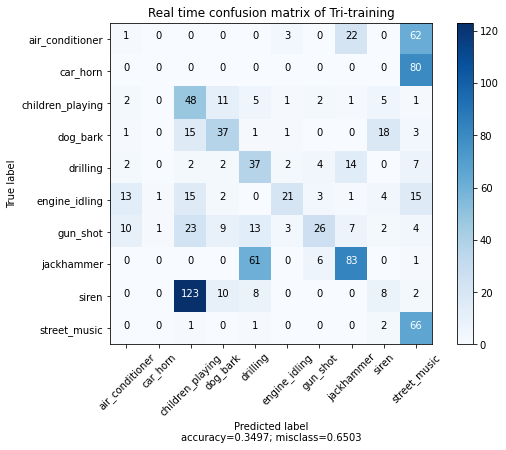

In [ ]:
plot_confusion_matrix(cm, label, normalize=False)

Tri-training with disagreement


In [ ]:
# all models tri training with disagreement predictions 

list=['Air_conditioner','Car_horn','Children_play','Dog_bark','Drilling','Engine_idling','Gun_shot','Jackhammer','Siren','Street_music']
import glob
sample_r = []
feature = []

import keras
m1 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/CRNN.h5')  
m2 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/MLP.h5') 
m3 = keras.models.load_model('/content/drive/MyDrive/ML_A/Tri train/3. Tri-S/LSTM.h5')  

#############################################Feature extraction#############################################################
def parser(row):
    # Function to load files and extract features
    feature=[]
    f=glob.glob(row+'/'+'*.wav')
    for i in range(len(f)):
        #file_name = '/content/drive/MyDrive/Dataset/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        X, sample_rate = librosa.load(f[i], res_type='kaiser_fast') 
        from sklearn import preprocessing
        #X=preprocessing.normalize(X.reshape(16,8)).reshape(128,)
        
        feature.append(X)
        sample_r.append(sample_rate)
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0) 
        
        #print(mels.shape)      
        #feature.append(mels)
        #label.append(df["classID"][i])
    return feature, sample_r


######################Extracting features of all the wav files of all classes##########################################################
features=[]
X_total=[]
y_total_pred=[]
y_correct=[]
y_real=[]
index=0
for i in list:
  F=[]
  F, sample_rate = parser('/content/drive/MyDrive/ML_N/'+i)
  print(index)
  
  features.append(F)
  x_ = []
  X_test=[]
  y_pred=[]
  print(len(F))
  for j in range(len(F)):
    y_real.append(index)
    mels = np.mean(librosa.feature.melspectrogram(y=F[j], sr=sample_rate[j]).T,axis=0)
    #print(mels.shape)
    from sklearn import preprocessing
    mels=preprocessing.normalize(mels.reshape(16,8)).reshape(128,)
    mels=np.reshape(mels, (128,))
    x_.append(mels)
    y_correct.append(index-1)
    X_total.append(mels)
  print(len(x_))
  x=np.array(x_)
  index+=1
  X_test.append(x)
  print(x.shape)
  y1 = m1.predict(x.reshape(len(x), 16,8,1))
  y2 = m2.predict(x)
  y3 = m3.predict(x.reshape(len(x), 16,8))

  y = []
  for k in range(len(y1)):
    p_1 = y1[k][np.argmax(y1[k])]
    p_2 = y2[k][np.argmax(y2[k])]
    p_3 = y3[k][np.argmax(y3[k])]
    p_max = max(max(p_1, p_2), p_3)
    if np.argmax(y1[k])==np.argmax(y2[k]) and (p_1>=0.85 or p_2>=0.85):
      y.append(y1[k])
    elif np.argmax(y2[k])==np.argmax(y3[k]) and (p_2>=0.85 or p_3>=0.85):
      y.append(y2[k])
    elif np.argmax(y3[k])==np.argmax(y1[k]) and (p_3>=0.85 or p_1>=0.85):
      y.append(y3[k])
    else:
      if p_max==p_1:
        y.append(y1[k])
      elif p_max==p_2:
        y.append(y2[k])
      elif p_max==p_3:
        y.append(y3[k])


  y = np.argmax(y, axis=1)
  
  y_total_pred=y_total_pred+y.tolist()
  print(y)


#print(X_total.shape,y_total_pred.shape)

0
88
88
(88, 128)
[5 7 9 9 3 5 5 5 9 5 5 9 9 9 9 5 5 9 9 9 5 9 5 9 5 9 9 5 0 9 9 5 5 9 5 9 5
 5 9 5 9 5 9 5 9 3 9 9 5 9 9 5 9 9 3 9 9 5 5 5 9 9 5 9 5 5 9 5 9 9 9 9 5 5
 5 5 5 9 5 5 5 5 5 9 9 2 5 5]
1
80
80
(80, 128)
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9]
2
76
76
(76, 128)
[3 3 8 2 8 7 8 3 3 6 2 8 4 2 3 9 3 2 3 3 2 2 2 3 2 3 2 2 3 3 8 5 3 9 1 4 8
 7 8 3 3 8 2 2 3 3 2 8 2 6 4 8 2 2 3 2 2 2 2 2 2 2 3 3 3 2 3 8 3 3 9 2 5 5
 7 0]
3
76
76
(76, 128)
[3 3 3 3 3 3 3 3 3 3 3 3 3 6 2 3 3 3 3 3 3 3 8 8 8 3 3 3 3 3 3 3 2 3 3 3 3
 3 3 2 2 2 6 2 2 2 2 2 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9
 0 9]
4
70
70
(70, 128)
[6 9 9 4 4 2 4 2 2 2 4 4 3 3 3 4 4 4 6 4 4 4 4 4 3 3 3 7 6 6 6 6 6 6 0 0 0
 0 4 4 4 4 4 4 4 5 4 4 4 4 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7]


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


5
75


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


75
(75, 128)
[9 9 9 0 2 0 0 9 9 9 9 5 9 9 8 7 9 5 7 9 9 9 9 9 9 9 9 9 9 5 0 5 5 5 5 5 0
 5 5 5 5 5 0 0 0 0 0 0 0 5 0 5 7 2 9 0 0 0 0 0 5 1 8 0 0 0 0 0 9 0 0 0 5 0
 7]
6
98
98
(98, 128)
[7 7 7 6 0 4 0 9 2 4 7 6 6 7 6 0 6 6 7 0 6 6 6 6 6 0 6 3 5 3 2 9 4 9 2 4 3
 2 0 5 6 3 6 2 2 6 6 2 6 6 6 6 6 7 3 0 6 0 0 4 0 6 2 6 6 0 0 6 7 7 3 4 6 3
 8 9 1 9 4 3 3 4 4 4 6 4 4 3 0 6 0 5 3 4 5 6 6 3]


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


7
151


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]


151
(151, 128)
[7 7 4 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 4
 7 7 7 7 7 7 7 7 4 7 7 3 7 4 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7
 7 7 7]
8
151
151
(151, 128)
[3 8 2 2 2 2 8 3 2 2 2 6 2 8 4 2 2 2 2 2 6 8 2 2 2 2 8 3 2 2 2 2 2 2 2 2 2
 2 2 8 3 2 2 2 2 2 3 2 2 2 2 2 8 3 2 2 2 2 2 4 8 2 2 2 2 8 3 2 2 2 2 2 8 3
 2 2 2 2 2 6 8 2 2 6 2 8 3 2 2 2 2 2 3 3 2 2 2 2 2 3 2 2 2 2 2 8 3 2 2 2 2
 2 3 2 2 2 2 2 8 3 6 2 2 2 2 4 8 2 2 6 2 8 8 3 2 2 2 2 2 4 8 2 2 2 2 2 9 2
 2 2 3]
9
70
70
(70, 128)
[6 8 9 9 8 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 8 9 9 9 9 3
 9 8 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 8 9 8]


In [ ]:
############################################## Getting no. of correct prediction########################
sum=0
#y=np.load('/content/drive/MyDrive/ML_N/Real_time_data/y.npy')
for i in range(len(y_total_pred)):
#  print(y_pred[i],y[i])
  if y_total_pred[i]==y_real[i]:
    sum=sum+1
print(sum/len(y_real))

0.38181818181818183


In [ ]:
from sklearn.metrics import confusion_matrix

label=[ 'air_conditioner', 'car_horn', 'children_playing','dog_bark', 'drilling', 'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music']
cm = confusion_matrix(y_real,y_total_pred, [0,1, 2, 3, 4, 5,6,7,8,9])

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Real time confusion matrix of Tri-training with disagreement', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('/content/drive/MyDrive/ML_A/tri train disagree.png')
    plt.show()

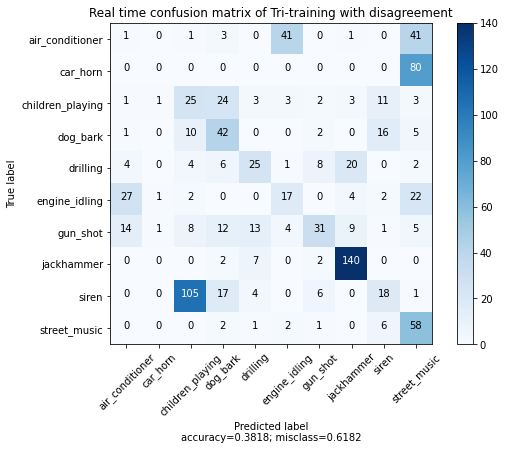

In [ ]:
plot_confusion_matrix(cm, label, normalize=False)